In [9]:
from math import isnan
from functools import total_ordering
import calendar
import zipfile
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings('ignore')

In [10]:
def load(asset: str, type: str = "call"):
    data = pd.read_csv(f'{asset}.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                   'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume', 'OpenInterest', 'IV', 'Delta', 'Gamma',
                   'Theta', 'Vega'])
    data['Expiration'] = pd.to_datetime(data['Expiration'])
    data['DataDate'] = pd.to_datetime(data['DataDate'])
    df_typed = data.loc[data['Type'] == type]
    return df_typed

In [11]:
def select_closest_dn_option_max_expiration_days(df):
    df['Days'] = (df['Expiration'] - df['DataDate']).astype('timedelta64[D]').astype(int)
    df2 = df.groupby('DataDate').apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] - 0.5).abs().argsort()[:1]]))
    max_expiration_days = df2.loc[df2['Days'].idxmax()]['Days']
    print(f'Max days option expiration is {max_expiration_days}')
    return df2

In [12]:
def filter_portfolio(portfolio_list: list, date: datetime.datetime):
    removed = []
    for l in portfolio_list:
        if l[1]['Expiration'] == date:
            removed.append(l)

    for r in removed:
        portfolio_list.remove(r)

    # print(f"after remove {len(portfolio_list)}")
    return removed

def calculate_delta_port(portfolio_list: list):
    delta_total = 0
    for p in portfolio_list:
        delta_total = delta_total + p[1]['Delta']

    return delta_total

In [13]:
def should_execute(spot, expired_today):
    total_minus = 0
    executed = 0
    for option in expired_today:
        strike = option[1]['Strike']
        if strike < spot:
            minus = strike - spot
            #print(f"option will be executed. Pay ${minus}")
            executed = executed + 1
            total_minus = total_minus + minus

    total_len = len(expired_today)
    if total_len > 0:
        print(f"From {total_len} expired options only {executed} were executed. Total minus {total_minus}")
    return total_minus

def visualize_balance(b):
    lists = sorted(b.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()

In [14]:
def simple_trading(df):
    balance = {0: .0}
    delta_port = {0: .0}
    option_number = {0: 0}
    min_expiration = 0
    max_expiration = 15
    max_days = 200

    portfolio = []
    max_delta = 1.5

    current_date = datetime.datetime.now()
    i = 0
    for row in df.iterrows():
        if i > max_days:
            break

        date = row[1]['DataDate']
        if date != current_date:
            print(f'Next date {date}')
            current_date = date
            i = i + 1
            balance[i] = balance[i - 1]
            delta_port[i] = delta_port[i - 1]
            option_number[i] = option_number[i - 1]
        # delta = 0
        # print(f" number of options in port {len(portfolio)}")
        # for p in portfolio:
        #     delta = delta + p[1]['Delta']
        # delta_port[i] = delta

        # execute current options
            spot = row[1]['UnderlyingPrice']
            expired_today = filter_portfolio(portfolio, date)

            delta_port[i] = delta_port[i] - calculate_delta_port(expired_today)
            option_number[i] = option_number[i] - len(expired_today)
            should_execute(spot, expired_today)

        days = row[1]['Days']
        if days > max_expiration or days < 1:
            continue

        delta = row[1]['Delta']
        new_delta = delta_port[i] + delta
        if max_delta < new_delta:
            continue

        delta_port[i] = new_delta
        bid = row[1]['Bid']
        balance[i] = balance[i] + bid
        option_number[i] = option_number[i] + 1

        portfolio.append(row)

    #print(balance)
    visualize_balance(balance)
    visualize_balance(delta_port)
    visualize_balance(option_number)

In [15]:
def simulate_simple_trading(asset: str, type: str = "call"):
    df = load(asset, type)
    df_days = select_closest_dn_option_max_expiration_days(df)
    simple_trading(df_days)

Simple simulation for AMZN
Max days option expiration is 858
Next date 2016-11-01 00:00:00
Next date 2016-11-02 00:00:00
Next date 2016-11-03 00:00:00
Next date 2016-11-04 00:00:00
From 1 expired options only 0 were executed. Total minus 0
Next date 2016-11-07 00:00:00
Next date 2016-11-08 00:00:00
Next date 2016-11-09 00:00:00
Next date 2016-11-10 00:00:00
Next date 2016-11-11 00:00:00
From 2 expired options only 0 were executed. Total minus 0
Next date 2016-11-14 00:00:00
Next date 2016-11-15 00:00:00
Next date 2016-11-16 00:00:00
Next date 2016-11-17 00:00:00
Next date 2016-11-18 00:00:00
From 2 expired options only 2 were executed. Total minus -60.319999999999936
Next date 2016-11-21 00:00:00
Next date 2016-11-22 00:00:00
Next date 2016-11-23 00:00:00
Next date 2016-11-25 00:00:00
From 2 expired options only 2 were executed. Total minus -60.74000000000001
Next date 2016-11-28 00:00:00
Next date 2016-11-29 00:00:00
Next date 2016-11-30 00:00:00
Next date 2016-12-01 00:00:00
Next dat

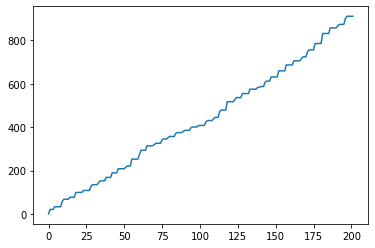

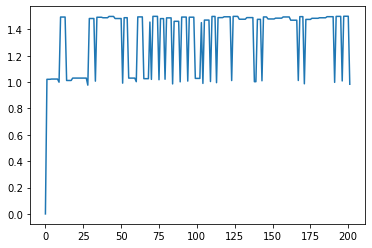

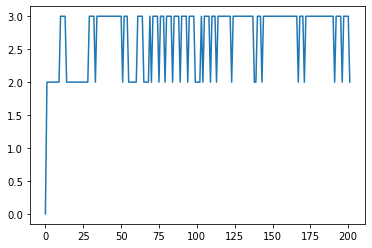

Simple simulation for GOOGL
Max days option expiration is 858
Next date 2016-11-01 00:00:00
Next date 2016-11-02 00:00:00
Next date 2016-11-03 00:00:00
Next date 2016-11-04 00:00:00
From 1 expired options only 0 were executed. Total minus 0
Next date 2016-11-07 00:00:00
Next date 2016-11-08 00:00:00
Next date 2016-11-09 00:00:00
Next date 2016-11-10 00:00:00
Next date 2016-11-11 00:00:00
From 2 expired options only 0 were executed. Total minus 0
Next date 2016-11-14 00:00:00
Next date 2016-11-15 00:00:00
Next date 2016-11-16 00:00:00
Next date 2016-11-17 00:00:00
Next date 2016-11-18 00:00:00
From 2 expired options only 1 were executed. Total minus -3.07000000000005
Next date 2016-11-21 00:00:00
Next date 2016-11-22 00:00:00
Next date 2016-11-23 00:00:00
Next date 2016-11-25 00:00:00
From 3 expired options only 3 were executed. Total minus -13.190000000000055
Next date 2016-11-28 00:00:00
Next date 2016-11-29 00:00:00
Next date 2016-11-30 00:00:00
Next date 2016-12-01 00:00:00
Next dat

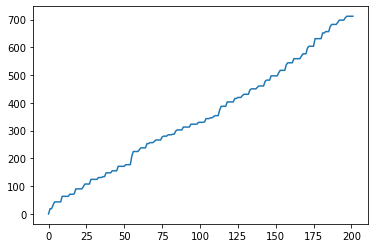

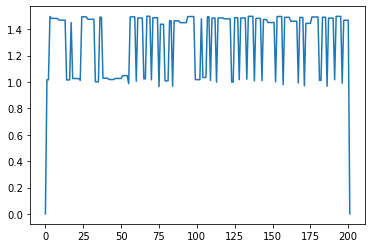

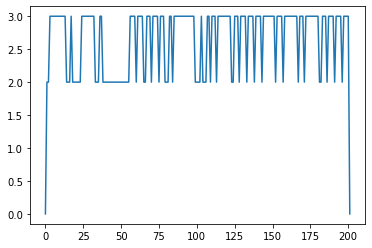

Simple simulation for NFLX
Max days option expiration is 858
Next date 2016-11-01 00:00:00
Next date 2016-11-02 00:00:00
Next date 2016-11-03 00:00:00
Next date 2016-11-04 00:00:00
From 1 expired options only 0 were executed. Total minus 0
Next date 2016-11-07 00:00:00
Next date 2016-11-08 00:00:00
Next date 2016-11-09 00:00:00
Next date 2016-11-10 00:00:00
Next date 2016-11-11 00:00:00
From 2 expired options only 0 were executed. Total minus 0
Next date 2016-11-14 00:00:00
Next date 2016-11-15 00:00:00
Next date 2016-11-16 00:00:00
Next date 2016-11-17 00:00:00
Next date 2016-11-18 00:00:00
From 2 expired options only 2 were executed. Total minus -1.4199999999999875
Next date 2016-11-21 00:00:00
Next date 2016-11-22 00:00:00
Next date 2016-11-23 00:00:00
Next date 2016-11-25 00:00:00
From 3 expired options only 2 were executed. Total minus -4.819999999999993
Next date 2016-11-28 00:00:00
Next date 2016-11-29 00:00:00
Next date 2016-11-30 00:00:00
Next date 2016-12-01 00:00:00
Next dat

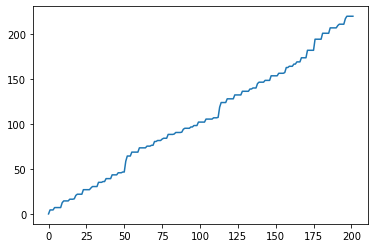

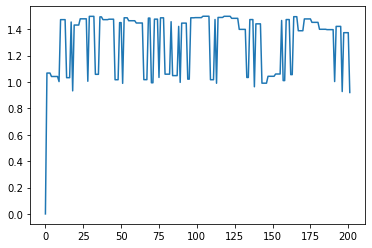

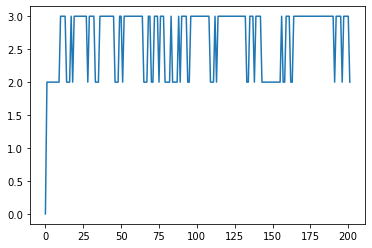

Simple simulation for MSFT
Max days option expiration is 945
Next date 2016-11-01 00:00:00
Next date 2016-11-02 00:00:00
Next date 2016-11-03 00:00:00
Next date 2016-11-04 00:00:00
From 2 expired options only 0 were executed. Total minus 0
Next date 2016-11-07 00:00:00
Next date 2016-11-08 00:00:00
Next date 2016-11-09 00:00:00
Next date 2016-11-10 00:00:00
Next date 2016-11-11 00:00:00
From 2 expired options only 1 were executed. Total minus -0.020000000000003126
Next date 2016-11-14 00:00:00
Next date 2016-11-15 00:00:00
Next date 2016-11-16 00:00:00
Next date 2016-11-17 00:00:00
Next date 2016-11-18 00:00:00
From 2 expired options only 2 were executed. Total minus -3.200000000000003
Next date 2016-11-21 00:00:00
Next date 2016-11-22 00:00:00
Next date 2016-11-23 00:00:00
Next date 2016-11-25 00:00:00
From 2 expired options only 2 were executed. Total minus -1.5600000000000023
Next date 2016-11-28 00:00:00
Next date 2016-11-29 00:00:00
Next date 2016-11-30 00:00:00
Next date 2016-12-

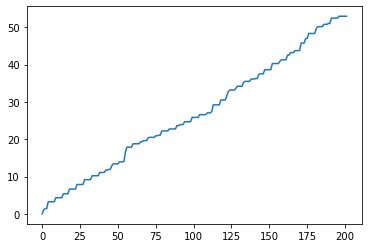

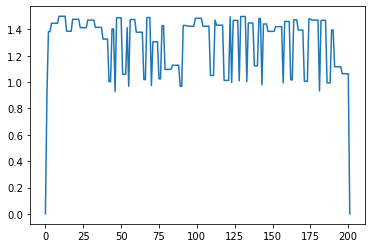

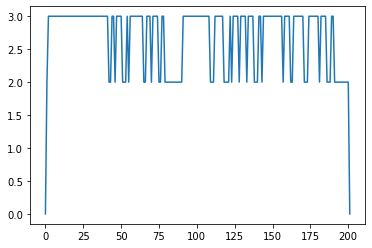

Simple simulation for FB


In [ ]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
for asset_name in assets:
    print(f"Simple simulation for {asset_name}")
    simulate_simple_trading(asset_name)